In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Parameters
learning_rate = 0.001
training_epochs = 500
display_step = 1
examples_to_show = 10
bs = 256

# tf input graph
X = tf.placeholder(tf.float32, [None, 784])
batch_size = tf.shape(X)[0]

In [3]:
# Store weights and biases

weights = {
    # convolution 1, 3x3 filter
    'wec1': tf.Variable(tf.random_normal([3, 3, 1, 32])),
    # convolution 2, 3x3 filter
    'wec2': tf.Variable(tf.random_normal([3, 3, 32, 64])),
    # fully connected layer 1, encoder
    'wef1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # fully connected layer 2, encoder
    'wef2': tf.Variable(tf.random_normal([1024, 256])),
    # fully connected layer 1, decoder
    'wdf1': tf.Variable(tf.random_normal([256, 1024])),
    # fully connected layer 2, decoder
    'wdf2': tf.Variable(tf.random_normal([1024, 7*7*64])),
    # deconvolution 1, 3x3 filter
    'wdd1': tf.Variable(tf.random_normal([3, 3, 32, 64])),
    # deconvolution 2, 3x3 filter
    'wdd2': tf.Variable(tf.random_normal([3, 3, 1, 32]))
}

biases = {
    'bec1': tf.Variable(tf.random_normal([32])),
    'bec2': tf.Variable(tf.random_normal([64])),
    'bef1': tf.Variable(tf.random_normal([1024])),
    'bef2': tf.Variable(tf.random_normal([256])),
    'bdf1': tf.Variable(tf.random_normal([1024])),
    'bdf2': tf.Variable(tf.random_normal([7*7*64])),
    'bdd1': tf.Variable(tf.random_normal([32])),
    'bdd2': tf.Variable(tf.random_normal([1]))
}

In [23]:
def activation(_input, activation='sigmoid'):
    if activation == 'relu':
        return tf.nn.relu(_input)
    elif activation == 'sigmoid':
        return tf.nn.sigmoid(_input)

In [24]:
# create model

reshaped_x = tf.reshape(X, (-1, 28, 28, 1))
print(reshaped_x.shape)

conv1 = tf.nn.conv2d(reshaped_x, weights['wec1'], strides=[1, 2, 2, 1], padding='SAME')
conv1 = tf.contrib.layers.batch_norm(conv1, epsilon=1e-5) # batch norm added
conv1 = activation(tf.add(conv1, biases['bec1']))
print(conv1.shape)

conv2 = tf.nn.conv2d(conv1, weights['wec2'], strides=[1, 2, 2, 1], padding='SAME')
conv2 = tf.contrib.layers.batch_norm(conv2, epsilon=1e-5) # batch norm added
conv2 = activation(tf.add(conv2, biases['bec2']))
print(conv2.shape)

fce1 = tf.reshape(conv2, (-1, 7*7*64))
fce1 = activation(tf.add(tf.matmul(fce1, weights['wef1']), biases['bef1']))
print(fce1.shape)

encode = activation(tf.add(tf.matmul(fce1, weights['wef2']), biases['bef2']))
print(encode.shape)

fcd1 = activation(tf.add(tf.matmul(encode, weights['wdf1']), biases['bdf1']))
print(fcd1.shape)

fcd2 = activation(tf.add(tf.matmul(fcd1, weights['wdf2']), biases['bdf2']))
fcd2 = tf.reshape(fcd2, (-1, 7, 7, 64))
print(fcd2.shape)

deconv1 = tf.nn.conv2d_transpose(fcd2, 
                                 weights['wdd1'], 
                                 output_shape=tf.stack([batch_size, 14, 14, 32]), 
                                 strides=[1, 2, 2, 1],
                                 padding='SAME')
deconv1 = tf.reshape(deconv1, (batch_size, 14, 14, 32))
deconv1 = tf.contrib.layers.batch_norm(deconv1, epsilon=1e-5) # batch norm added
deconv1 = activation(tf.add(deconv1, biases['bdd1']))
print(deconv1.shape)

deconv2 = tf.nn.conv2d_transpose(deconv1,
                                 weights['wdd2'],
                                 output_shape=tf.stack([batch_size, 28, 28, 1]),
                                 strides=[1, 2, 2, 1],
                                 padding='SAME')
deconv2 = tf.reshape(deconv2, (batch_size, 28, 28, 1))
deconv2 = tf.contrib.layers.batch_norm(deconv2, epsilon=1e-5) # batch norm added
deconv2 = activation(tf.add(deconv2, biases['bdd2']))
print(deconv2.shape)

decode = tf.reshape(deconv2, (-1, 784))

cost = tf.reduce_mean(tf.square(decode - X))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

(?, 28, 28, 1)
(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 1024)
(?, 256)
(?, 1024)
(?, 7, 7, 64)
(?, 14, 14, 32)
(?, 28, 28, 1)


In [25]:
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/bs)
    
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(bs)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_x})
            print("i:{0}, Cost:{1}".format(i, c))
        if epoch % display_step == 0:
            print('Epoch:', (epoch+1), 'Cost:', c)
    print('Optimzation finished!')
    
    save_path = saver.save(sess, "Saved_models/cnn_auto_mnist_sigmoid/conv_ae_model.ckpt")
    print("Model saved in file: %s" % save_path)


i:0, Cost:0.111866220832
i:1, Cost:0.106457836926
i:2, Cost:0.107444837689
i:3, Cost:0.105311892927
i:4, Cost:0.107507221401
i:5, Cost:0.100136347115
i:6, Cost:0.10128647089
i:7, Cost:0.102158486843
i:8, Cost:0.101551413536
i:9, Cost:0.0972151011229
i:10, Cost:0.0979288816452
i:11, Cost:0.0979917123914
i:12, Cost:0.0982137024403
i:13, Cost:0.0983902066946
i:14, Cost:0.0966763421893
i:15, Cost:0.0976730436087
i:16, Cost:0.0956696271896
i:17, Cost:0.0961155891418
i:18, Cost:0.0950447320938
i:19, Cost:0.0988218262792
i:20, Cost:0.0936489477754
i:21, Cost:0.0965562537313
i:22, Cost:0.0947278663516
i:23, Cost:0.0973327383399
i:24, Cost:0.0939196199179
i:25, Cost:0.0907167643309
i:26, Cost:0.0903971344233
i:27, Cost:0.0948089510202
i:28, Cost:0.0944688171148
i:29, Cost:0.0939424112439
i:30, Cost:0.0927604734898
i:31, Cost:0.0934249982238
i:32, Cost:0.0923789069057
i:33, Cost:0.0948507040739
i:34, Cost:0.0923756882548
i:35, Cost:0.0932828783989
i:36, Cost:0.0908588841558
i:37, Cost:0.09054676

KeyboardInterrupt: 

In [15]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "Saved_models/cnn_auto_mnist_sigmoid/conv_ae_model.ckpt")
    print("Model restored.")
    
    encode_decode = sess.run(decode, feed_dict={X: mnist.test.images[:examples_to_show]}) # first 10 rows from the test dataset

# compare the original images with the reconstructions
f, a = plt.subplots(2, 10, figsize=(10,2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28,28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28,28)))
plt.draw()

INFO:tensorflow:Restoring parameters from Saved_models/cnn_auto_mnist_sigmoid/conv_ae_model.ckpt
Model restored.


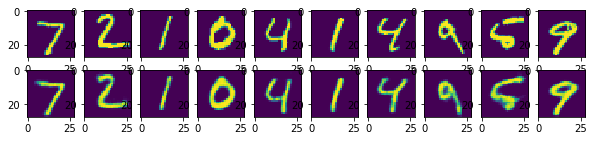

In [16]:
plt.show()

In [ ]:
img_org = plt.imshow(np.reshape(x, (28,28)))
plt.show()

In [ ]:
img_pred = plt.imshow(np.reshape(out, (28,28)))
plt.show()